#### IMPORT

In [1]:
import os, platform
import py7zr

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [2]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 37
TIMESTEPS = 1
EPOCH=200
BATCH_SIZE=100

SPLIT_RATIO=0.2

###############
# # preview # #
###############
f = False
t = True

# checking dataset
CHECK_BLANKS = True
CHECK_CLASS_IMBALANCE = True

# evaluate suitable kfold number and kfold model
MIN_KFOLD = 2
MAX_KFOLD = 11
N_KFOLD = 5
EVAL_KFOLD_NUM = False
EVAL_KFOLD_MODEL = False
PERFORM_KFOLD = True

# model testing
TEST_MODEL = True
CON_MATRIX = True
ROC_GRAPH = True

###############
# # dataset # #
###############
CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 3
        
DATASET_DIR_NAME = "dataset\set01\\02_class"
SAMPLE_DATASET_NAME = "train"
ACTUAL_DATASET_NAME = "test"

MODEL_DIR_NAME = "dataset\set01\\02_class"
MODEL_NAME = "model_" + "set01_02_class"

RESULT_DIR_NAME = "dataset\set01\\02_class"
RESULT_NAME = "result_" + "set01_02_class"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".csv")
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME + ".h5")

RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

C:\Users\andy\Documents\Github\ict4001-cap\dataset\set01\01_original


In [3]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")
    
if os.path.exists(SAMPLE_DATASET_PATH) is True:
    print(f"Training dataset exists at: {SAMPLE_DATASET_PATH}")
else:
    try:
        SAMPLE_7Z_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".7z")
        with py7zr.SevenZipFile(SAMPLE_7Z_PATH, mode='r') as z:
            z.extractall(path=DATASET_DIR_PATH)
        print(f"Decompress 7z file to: {SAMPLE_7Z_PATH}")
    except:
        print("Error: Failed to decompress 7z file.")

Dataset directory exists at: C:\Users\andy\Documents\Github\ict4001-cap\dataset\set01\01_original
Model directory exists at: C:\Users\andy\Documents\Github\ict4001-cap\dataset\set01\01_original


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [4]:
#create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))

    # softmax for multi-class classification
    model.add(Flatten())
    print("There are a total of " + str(n_classes) + " classes.")
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model

In [5]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)

    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb, lb.classes_.tolist()

In [6]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X

#### LOAD DATASET

In [7]:
# load dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

,Subject,Class,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T2-RF|6+7,T2-D|7,T2-I|7+8,T2-PF|7+8,T2-RF|7+8,T2-D|8,T2-I|8+9,T2-PF|8+9,T2-RF|8+9,T2-D|9
0,andy,3,mad wabble,0.155289,0.234703,0.091736,0.079413,0.142967,0.238084,0.072560,...,0.165704,0.119107,0.171939,0.040368,0.052832,0.131571,0.188983,0.075754,0.057412,0.113230
1,andy,3,bad reread,0.116150,0.285436,0.085726,0.169286,0.199709,0.248351,0.127091,...,0.076081,0.160108,0.271197,0.069895,0.111089,0.201302,0.291623,0.135957,0.090321,0.155666
2,andy,3,ink sienna,0.118185,0.273710,0.114184,0.155524,0.159526,0.248386,0.106931,...,0.196050,0.086095,0.257720,0.139502,0.171624,0.118217,0.253027,0.124216,0.134809,0.128811
3,andy,3,ion doxies,0.082255,0.330661,0.189420,0.248406,0.141242,0.283131,0.142228,...,0.124682,0.141366,0.203498,0.086235,0.062132,0.117263,0.199387,0.054129,0.082124,0.145257
4,andy,3,hey plains,0.106697,0.214285,0.117489,0.107588,0.096796,0.225085,0.090808,...,0.109095,0.125539,0.198049,0.046005,0.072510,0.152043,0.221190,0.082523,0.069147,0.138667


#### CHECK DATASET

Checking for blanks...
No blank value has been found.
Checking for class imbalance...


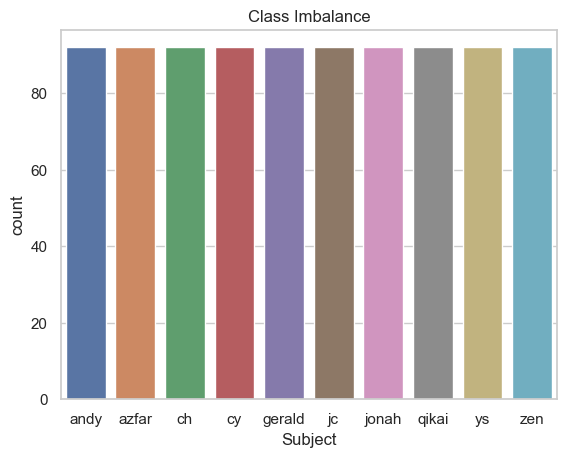

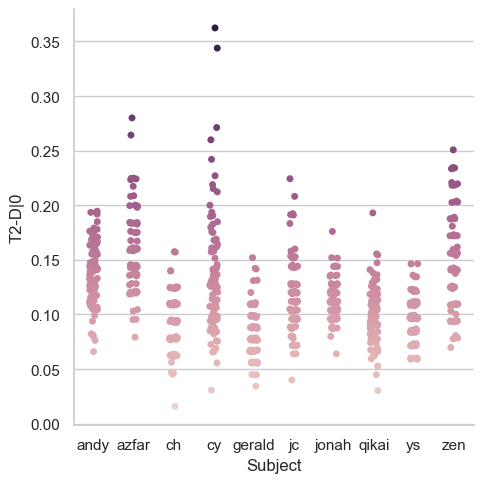

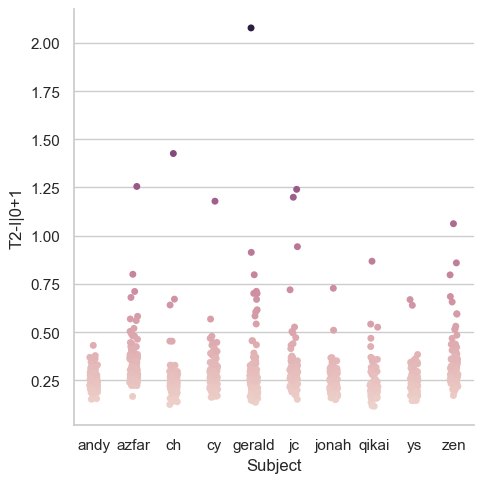

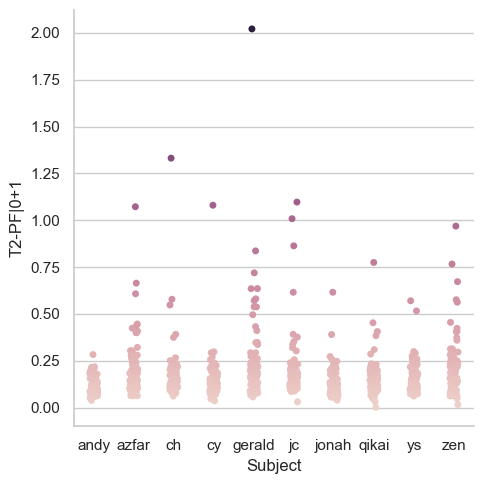

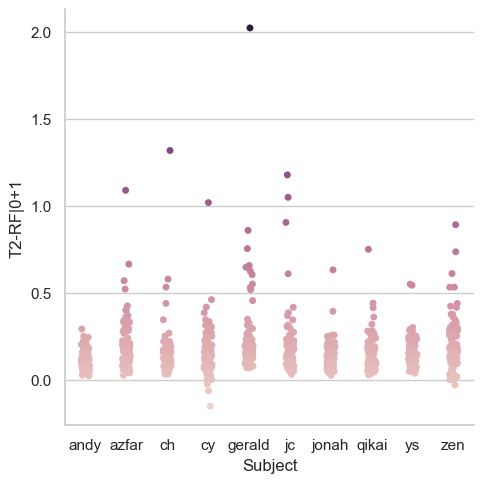

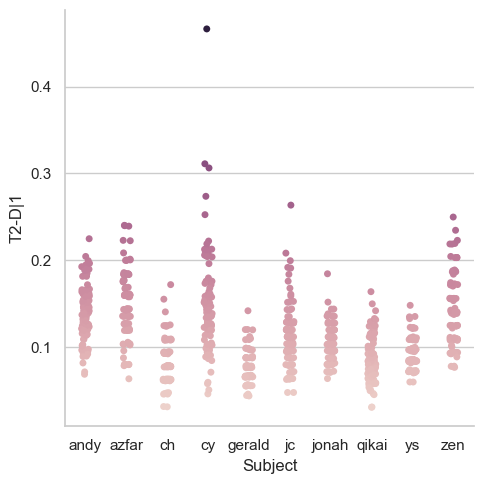

In [8]:
########################
# # check for blanks # #
########################
if CHECK_BLANKS is True:
    # checking for blanks
    print("Checking for blanks...")
    if df.isnull().values.any() is True:
        df = df.dropna(axis=0, how="any")
        print("Blank rows has been dropped.")
    else:
        print("No blank value has been found.")
        
#################################
# # check for class imbalance # #
#################################
if CHECK_CLASS_IMBALANCE is True:
    print("Checking for class imbalance...")
    sns.countplot(x=CLASSES_COL_NAME, data=df).set_title("Class Imbalance")
#     df.loc[(df!=0).any(axis=1)]
    plt.show()

sns.catplot(x="Subject", y="T2-D|0", hue="T2-D|0", data=df, legend=False)
sns.catplot(x="Subject", y="T2-I|0+1", hue="T2-I|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-PF|0+1", hue="T2-PF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-RF|0+1", hue="T2-RF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-D|1", hue="T2-D|1", data=df, legend=False)

#### PREPARE DATASET
- Split data based on X / Features and Y / Classes
- Binarize Y into binary labels

In [9]:
X, Y, lb, class_list = prepare_dataset(df)
n_classes = len(class_list)
print(f"Number of Classes: {n_classes}")

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'ch' 'cy' 'gerald' 'jc' 'jonah' 'qikai' 'ys' 'zen']


X | Features | Dataset Shape: (920, 37)
Y | Classes  | Dataset Shape: (920, 10)


#### SPLIT DATASET
- Split dataset into train set and test set 0.8 / 0.2

In [10]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED)

float64
float32
float64
float32
X train shape: (736, 1, 37)
Y train shape: (736, 10)
X test shape: (184, 1, 37)
Y test shape: (184, 10)
Number of Classes: 10


#### PERFORM VALIDATION (w KFold Validation)
- Evaluate best KFold Validation
- Generate loss and accuracy graph
- Perform KFold validation

##### Evaluate suitable folds for kfold validation

In [11]:
###############################################
# # evaluate suitable kfold value for model # #
###############################################
def evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD):
    
    # evaluate the model    
    folds = range(MIN_KFOLD, MAX_KFOLD)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print(f"No. of Folds: {k} | Accuracy: {k_mean*100:.3f} | Min: {k_min*100:.3f} | Max: {k_max*100:.3f}")
        
        # store mean accuracy and min and max relative to the mean
        means.append(k_mean)
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    clear_output(wait=True)
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
if EVAL_KFOLD_NUM is True:
    evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD)
else:
    print("EVAL_KFOLD_NUM is not True")

EVAL_KFOLD_NUM is not True


##### Generate kfold validation accuracy and loss

In [12]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print(f"Accuracy | Mean: {np.mean(scores)*100:.3f} | Std: {np.std(scores)*100:.3f} | Length/no.: {len(scores)}")
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    clear_output(wait=True)
    plt.show()
    
if EVAL_KFOLD_MODEL is True:
    evaluate_kfold_model(X_train, y_train, SEED)
else:
    print("EVAL_KFOLD_MODEL is not true")

EVAL_KFOLD_MODEL is not true


##### Perform Actual KFold validation

In [13]:
if PERFORM_KFOLD is True:
    # create model
    model = create_model()
    kfold = KFold(n_splits=N_KFOLD, shuffle=True, random_state=SEED)
    valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)
else:
    print("PERFORM_KFOLD is not true.")

There are a total of 10 classes.
Epoch 1/100
6/6 [==============================] - 12s 32ms/step - loss: 2.7268 - accuracy: 0.0782
Epoch 2/100
6/6 [==============================] - 0s 33ms/step - loss: 2.6366 - accuracy: 0.0952
Epoch 3/100
6/6 [==============================] - 0s 33ms/step - loss: 2.6037 - accuracy: 0.0867
Epoch 4/100
6/6 [==============================] - 0s 32ms/step - loss: 2.5424 - accuracy: 0.1020
Epoch 5/100
6/6 [==============================] - 0s 32ms/step - loss: 2.5172 - accuracy: 0.0935
Epoch 6/100
6/6 [==============================] - 0s 32ms/step - loss: 2.4880 - accuracy: 0.0884
Epoch 7/100
6/6 [==============================] - 0s 32ms/step - loss: 2.4481 - accuracy: 0.0901
Epoch 8/100
6/6 [==============================] - 0s 32ms/step - loss: 2.4230 - accuracy: 0.0918
Epoch 9/100
6/6 [==============================] - 0s 32ms/step - loss: 2.4199 - accuracy: 0.0850
Epoch 10/100
6/6 [==============================] - 0s 33ms/step - loss: 2.3931 - ac

6/6 [==============================] - 0s 33ms/step - loss: 1.8964 - accuracy: 0.2122
Epoch 65/100
6/6 [==============================] - 0s 32ms/step - loss: 1.8893 - accuracy: 0.2343
Epoch 66/100
6/6 [==============================] - 0s 32ms/step - loss: 1.8816 - accuracy: 0.2377
Epoch 67/100
6/6 [==============================] - 0s 32ms/step - loss: 1.8997 - accuracy: 0.2071
Epoch 68/100
6/6 [==============================] - 0s 32ms/step - loss: 1.9107 - accuracy: 0.2020
Epoch 69/100
6/6 [==============================] - 0s 33ms/step - loss: 1.9002 - accuracy: 0.2173
Epoch 70/100
6/6 [==============================] - 0s 33ms/step - loss: 1.8608 - accuracy: 0.2479
Epoch 71/100
6/6 [==============================] - 0s 33ms/step - loss: 1.8415 - accuracy: 0.2835
Epoch 72/100
6/6 [==============================] - 0s 32ms/step - loss: 1.8537 - accuracy: 0.2394
Epoch 73/100
6/6 [==============================] - 0s 32ms/step - loss: 1.8160 - accuracy: 0.2428
Epoch 74/100
6/6 [=====

6/6 [==============================] - 0s 35ms/step - loss: 2.3478 - accuracy: 0.0985
Epoch 27/100
6/6 [==============================] - 0s 33ms/step - loss: 2.3383 - accuracy: 0.0934
Epoch 28/100
6/6 [==============================] - 0s 34ms/step - loss: 2.3466 - accuracy: 0.0832
Epoch 29/100
6/6 [==============================] - 0s 34ms/step - loss: 2.3428 - accuracy: 0.0968
Epoch 30/100
6/6 [==============================] - 0s 34ms/step - loss: 2.3449 - accuracy: 0.0934
Epoch 31/100
6/6 [==============================] - 0s 34ms/step - loss: 2.3256 - accuracy: 0.1019
Epoch 32/100
6/6 [==============================] - 0s 33ms/step - loss: 2.3227 - accuracy: 0.0951
Epoch 33/100
6/6 [==============================] - 0s 33ms/step - loss: 2.3100 - accuracy: 0.1256
Epoch 34/100
6/6 [==============================] - 0s 39ms/step - loss: 2.3145 - accuracy: 0.1053
Epoch 35/100
6/6 [==============================] - 0s 34ms/step - loss: 2.2923 - accuracy: 0.1307
Epoch 36/100
6/6 [=====

6/6 [==============================] - 0s 34ms/step - loss: 1.7523 - accuracy: 0.2784
Epoch 90/100
6/6 [==============================] - 0s 33ms/step - loss: 1.7846 - accuracy: 0.2683
Epoch 91/100
6/6 [==============================] - 0s 34ms/step - loss: 1.7356 - accuracy: 0.2683
Epoch 92/100
6/6 [==============================] - 0s 33ms/step - loss: 1.7444 - accuracy: 0.2852
Epoch 93/100
6/6 [==============================] - 0s 34ms/step - loss: 1.7706 - accuracy: 0.2818
Epoch 94/100
6/6 [==============================] - 0s 34ms/step - loss: 1.7732 - accuracy: 0.2513
Epoch 95/100
6/6 [==============================] - 0s 34ms/step - loss: 1.7434 - accuracy: 0.2937
Epoch 96/100
6/6 [==============================] - 0s 34ms/step - loss: 1.7297 - accuracy: 0.3056
Epoch 97/100
6/6 [==============================] - 0s 34ms/step - loss: 1.7264 - accuracy: 0.2971
Epoch 98/100
6/6 [==============================] - 0s 34ms/step - loss: 1.7163 - accuracy: 0.3192
Epoch 99/100
6/6 [=====

##### Get Validation Accuracy

In [14]:
if PERFORM_KFOLD is True:
    print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))
else:
    print("PERFORM_KFOLD is not true.")

Validation Accuracy of 30.84% (with standard deviation of 4.31%)


#### FIT MODEL FOR TESTING
- Fit the Model
- View Accuracy and Loss Graph
- View Model Summary

In [15]:
#####################
# # fit the model # #
#####################

if TEST_MODEL is True:
    model = create_model()
    es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                       verbose=1)
    history = model.fit(X_train, y_train, callbacks=es, verbose=1)

There are a total of 10 classes.
Epoch 1/100
8/8 [==============================] - 12s 35ms/step - loss: 2.4983 - accuracy: 0.1087
Epoch 2/100
8/8 [==============================] - 0s 35ms/step - loss: 2.4323 - accuracy: 0.1141
Epoch 3/100
8/8 [==============================] - 0s 39ms/step - loss: 2.4069 - accuracy: 0.0978
Epoch 4/100
8/8 [==============================] - 0s 37ms/step - loss: 2.3783 - accuracy: 0.1182
Epoch 5/100
8/8 [==============================] - 0s 35ms/step - loss: 2.3572 - accuracy: 0.1005
Epoch 6/100
8/8 [==============================] - 0s 34ms/step - loss: 2.3483 - accuracy: 0.1168
Epoch 7/100
8/8 [==============================] - 0s 35ms/step - loss: 2.3483 - accuracy: 0.1155
Epoch 8/100
8/8 [==============================] - 0s 35ms/step - loss: 2.3454 - accuracy: 0.1060
Epoch 9/100
8/8 [==============================] - 0s 35ms/step - loss: 2.3543 - accuracy: 0.1046
Epoch 10/100
8/8 [==============================] - 0s 35ms/step - loss: 2.3287 - ac

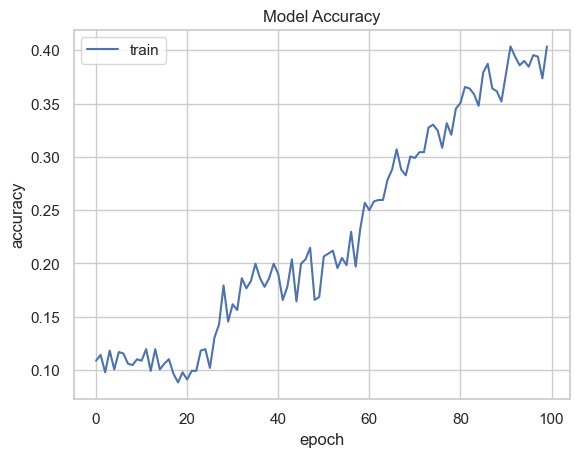

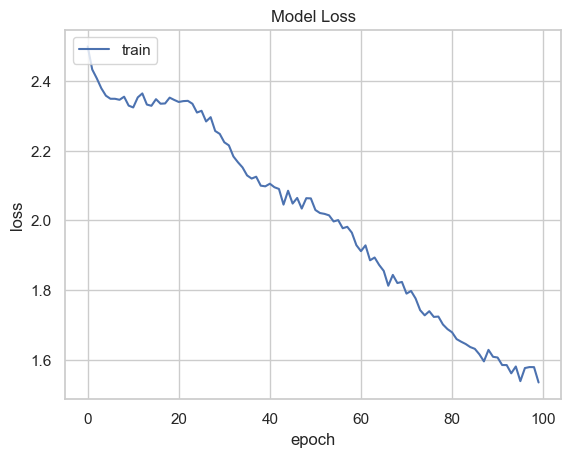

In [16]:
if TEST_MODEL is True:
    ##########################
    # # get model accuracy # #
    ##########################
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    ######################
    # # get model loss # #
    ######################
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [17]:
if TEST_MODEL is True:
    ##########################
    # # view model summary # #
    ##########################
    model.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 256)            301056    
                                                                 
 dense_25 (Dense)            (None, 1, 256)            65792     
                                                                 
 dropout_20 (Dropout)        (None, 1, 256)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 1, 256)           1024      
 chNormalization)                                                
                                                                 
 lstm_21 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dense_26 (Dense)            (None, 1, 128)            16512     
                                                      

#### MODEL TESTING
- Get Model Accuracy on the Test Dataset
- Generate Confusion Matrix
- Generate ROC Curves
- Save the Model if Appropriate

In [18]:
if TEST_MODEL is True:
    y_pred = model.predict_proba(X_test)

    # evaluate predictions
    acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    print("Testing accuracy: %.3f%%" % (acc*100))

6/6 [==============================] - 3s 9ms/step
184
Testing accuracy: 43.478%


##### Confusion Matrix

184 is the number of test value in kfold_val / train_test_split


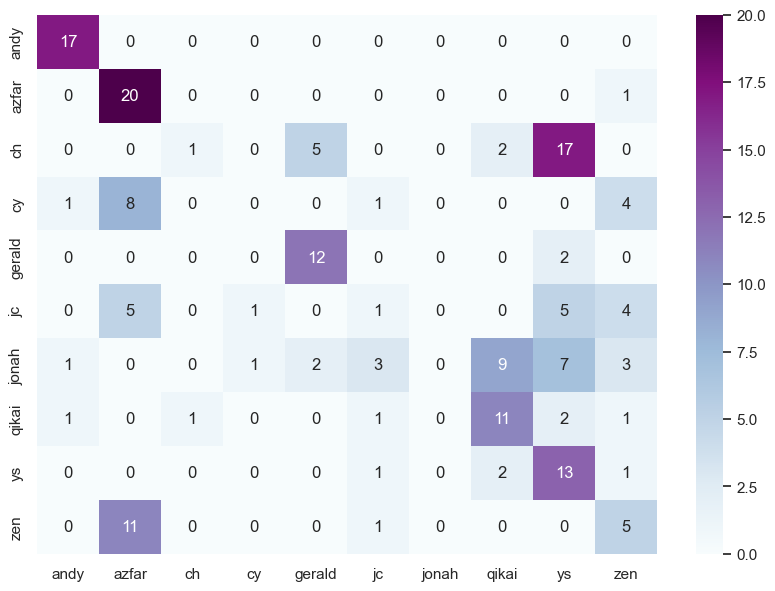

In [19]:
if TEST_MODEL is True and CON_MATRIX is True:
    # confusion matrix
    print(str(len(y_pred)) + " is the number of test value in kfold_val / train_test_split")
    cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                         columns = [i for i in np.unique(lb.inverse_transform(y_test))])

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

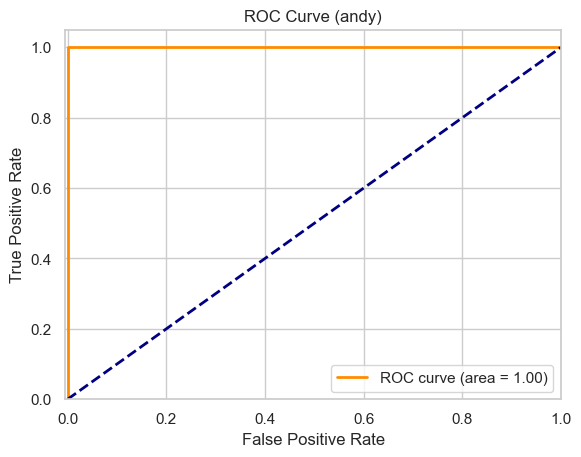

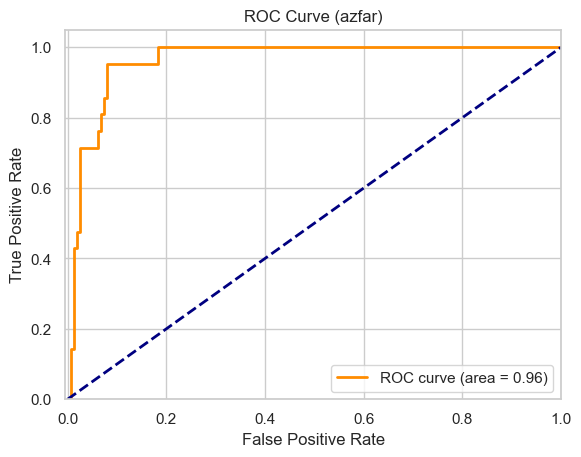

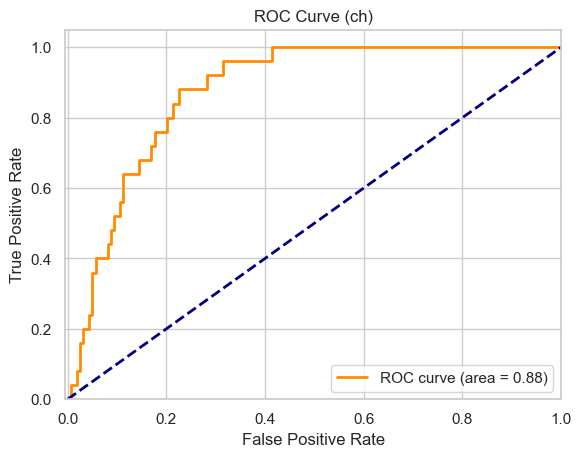

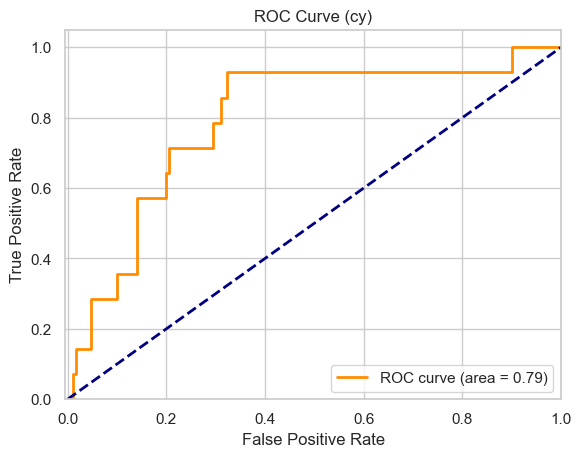

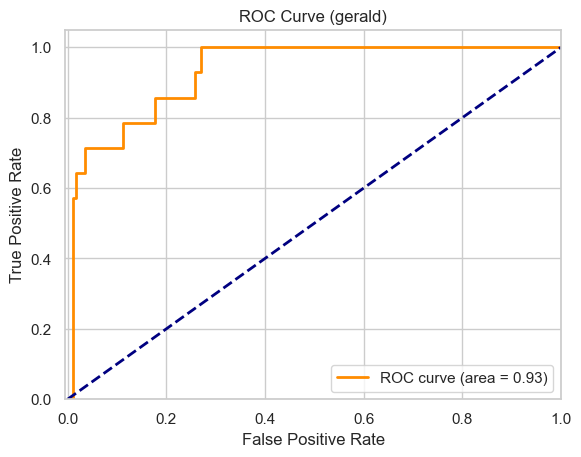

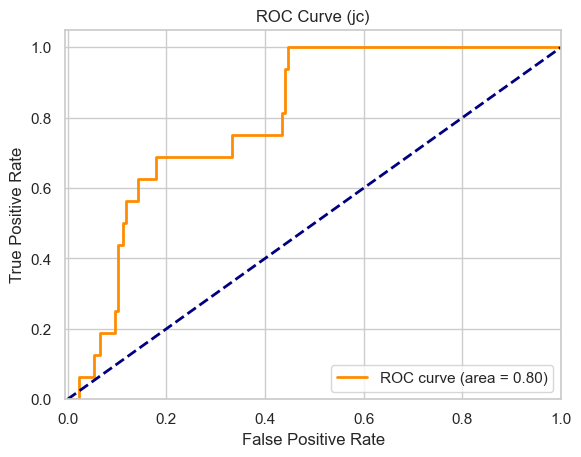

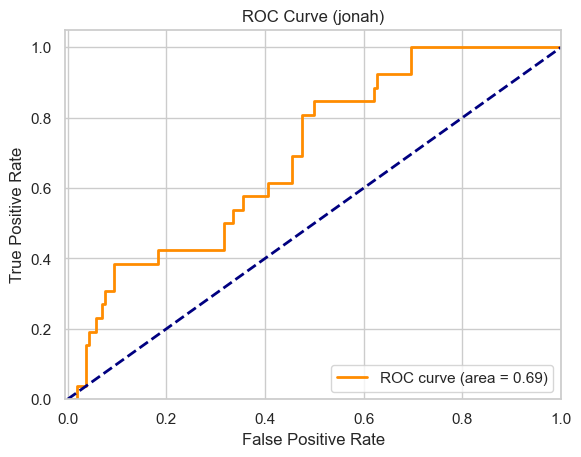

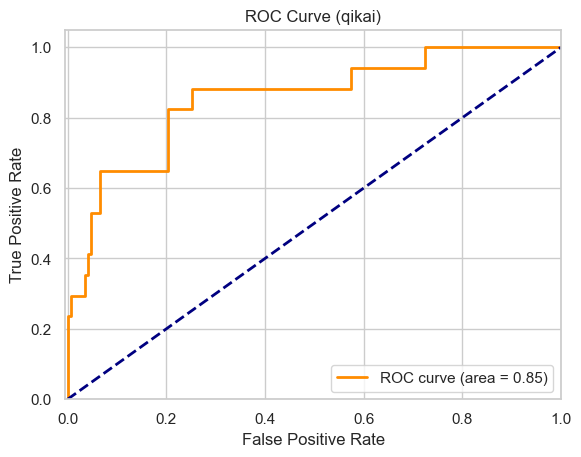

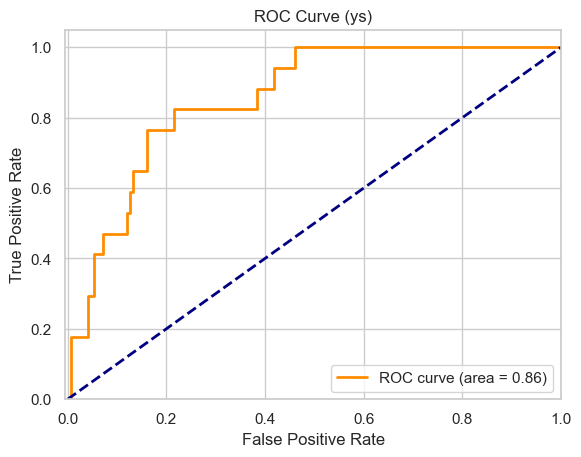

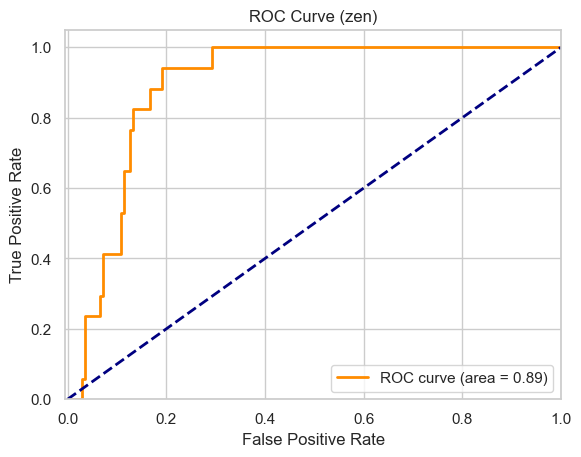

In [20]:
if TEST_MODEL is True and ROC_GRAPH is True: # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.figure()
        lw = 2
        plt.plot(
            fpr[i],
            tpr[i],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[i],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
        plt.legend(loc="lower right")
        plt.show()

##### ROC Curve (Multiclass)

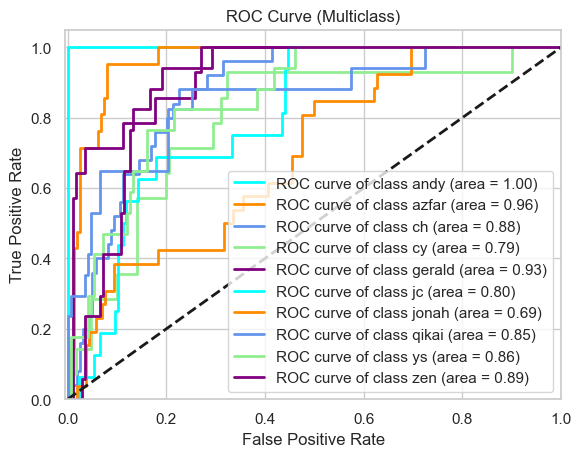

In [21]:
if TEST_MODEL is True and ROC_GRAPH is True:
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    # plt.figure()
    # plt.plot(
    #     fpr["micro"],
    #     tpr["micro"],
    #     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    #     color="deeppink",
    #     linestyle=":",
    #     linewidth=4,
    # )

    # plt.plot(
    #     fpr["macro"],
    #     tpr["macro"],
    #     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    #     color="navy",
    #     linestyle=":",
    #     linewidth=4,
    # )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Average)

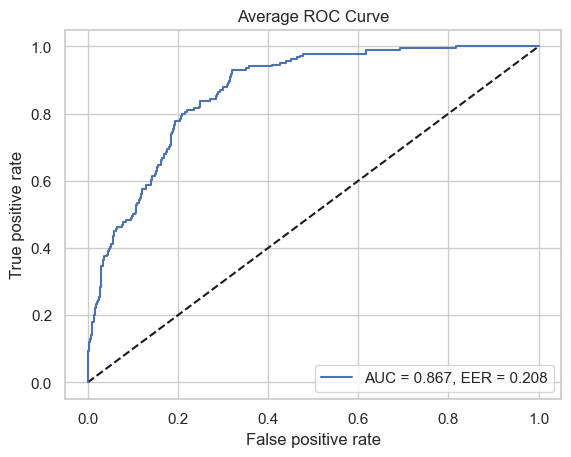

In [22]:
if TEST_MODEL is True and ROC_GRAPH is True:
    fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

    # calculate equal-error-rate
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='best')
    plt.show()

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [23]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb, class_list = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'ch' 'cy' 'gerald' 'jc' 'jonah' 'qikai' 'ys' 'zen']


X | Features | Dataset Shape: (920, 37)
Y | Classes  | Dataset Shape: (920, 10)
There are a total of 10 classes.
Epoch 1/100
10/10 [==============================] - 12s 33ms/step - loss: 2.5849 - accuracy: 0.0924
Epoch 2/100
10/10 [==============================] - 0s 33ms/step - loss: 2.5220 - accuracy: 0.1011
Epoch 3/100
10/10 [==============================] - 0s 33ms/step - loss: 2.4667 - accuracy: 0.0859
Epoch 4/100
10/10 [==============================] - 0s 33ms/step - loss: 2.4313 - accuracy: 0.1065
Epoch 5/100
10/10 [==============================] - 0s 33ms/step - loss: 2.4235 - accuracy: 0.0913
Epoch 6/100
10/10 [==============================] - 0s 33ms/step - loss: 2.4092 - accuracy: 0.1043
Epoch 7/100
10/10 [==============================] - 0s 33ms/step - loss: 2.3816 - accuracy: 0.0880
Epoch 8/100
10/10 [==============================] - 0s 36ms/step - loss: 2.383

10/10 [==============================] - 0s 32ms/step - loss: 1.5620 - accuracy: 0.3446
Epoch 81/100
10/10 [==============================] - 0s 32ms/step - loss: 1.5747 - accuracy: 0.3391
Epoch 82/100
10/10 [==============================] - 0s 33ms/step - loss: 1.5764 - accuracy: 0.3337
Epoch 83/100
10/10 [==============================] - 0s 32ms/step - loss: 1.5715 - accuracy: 0.3239
Epoch 84/100
10/10 [==============================] - 0s 33ms/step - loss: 1.5859 - accuracy: 0.3065
Epoch 85/100
10/10 [==============================] - 0s 32ms/step - loss: 1.5848 - accuracy: 0.3152
Epoch 86/100
10/10 [==============================] - 0s 32ms/step - loss: 1.5703 - accuracy: 0.3402
Epoch 87/100
10/10 [==============================] - 0s 32ms/step - loss: 1.6026 - accuracy: 0.3174
Epoch 88/100
10/10 [==============================] - 0s 32ms/step - loss: 1.5778 - accuracy: 0.3304
Epoch 89/100
10/10 [==============================] - 0s 32ms/step - loss: 1.5525 - accuracy: 0.3489
Epo

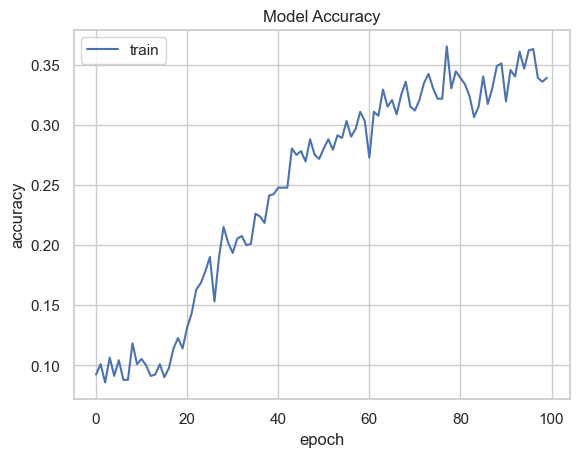

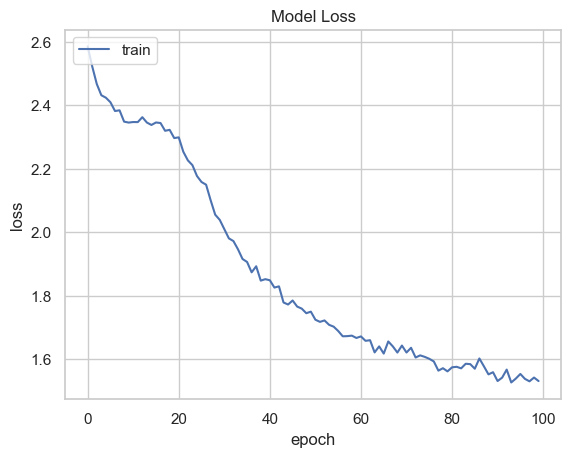

In [24]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [25]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [26]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [27]:
# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

,Subject,Class,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T2-RF|6+7,T2-D|7,T2-I|7+8,T2-PF|7+8,T2-RF|7+8,T2-D|8,T2-I|8+9,T2-PF|8+9,T2-RF|8+9,T2-D|9
0,andy,3,why margin,0.156546,0.305911,0.149060,0.149365,0.156852,0.276707,0.203404,...,0.211456,0.157810,0.181083,0.065032,0.023273,0.116051,0.152623,0.033008,0.036572,0.119616
1,andy,3,war encalm,0.160672,0.335976,0.110433,0.175304,0.225543,0.271715,0.103903,...,0.222109,0.189098,0.239651,0.133426,0.050553,0.106225,0.214052,0.070148,0.107827,0.143904
2,andy,4,hood whips,0.132462,0.183651,0.102099,0.051189,0.081552,0.254179,0.131667,...,0.060127,0.141966,0.191998,0.056452,0.050031,0.135546,0.240348,0.090543,0.104802,0.149805
3,andy,4,shim sweat,0.151514,0.161692,0.042774,0.010178,0.118918,0.178971,0.065487,...,0.203171,0.150809,0.246943,0.104717,0.096134,0.142226,0.237926,0.076469,0.095700,0.161457
4,andy,5,henry haji,0.128684,0.227950,0.091504,0.099266,0.136446,0.238963,0.099947,...,0.141130,0.160158,0.299132,0.167161,0.138973,0.131971,0.211203,0.059170,0.079232,0.152033


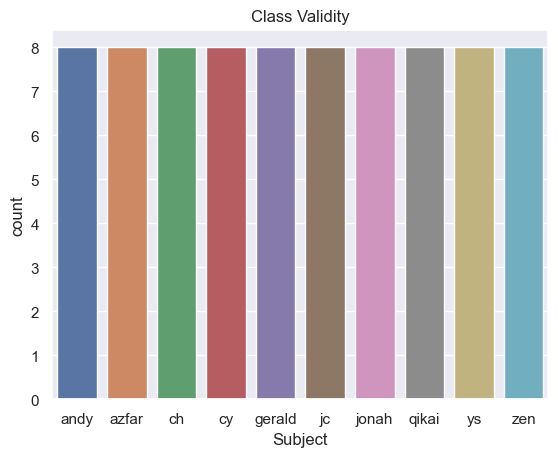

In [28]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [29]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['andy', 'azfar', 'ch', 'cy', 'gerald', 'jc', 'jonah', 'qikai', 'ys', 'zen']


In [32]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

print("Accuracy of the Model is: " + str(match_header))

3/3 [==============================] - 0s 10ms/step
Accuracy of the Model is: 25/80 (31.25%)
